In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
FOLDERNAME =  "SOCAIT/Fitness"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME/
!ls

Mounted at /content/drive
/content/drive/My Drive/SOCAIT/Fitness
'Copy of fitness_data_analysis.ipynb'	 mistral-recipe-finetune	 SFT.ipynb
'Copy of MistralFinetunePhiloso.ipynb'	 nutrition_data_analysis.ipynb	 TRL.ipynb
 fitness_data				 Nutrition_EDA.ipynb		 wandb
 fitness_data_analysis.ipynb		 Recipe_Mistral_Inference


In [ ]:
import pandas as pd

# user_interactions_df = pd.read_csv("fitness_data/nutrition/recipes/RAW_interactions.csv")
# recipes_df = pd.read_csv("fitness_data/nutrition/recipes/RAW_recipes.csv")
recipes_df = pd.read_csv("fitness_data/nutrition/recipes_rewards.csv")


In [ ]:
recipes_df.head()

,Unnamed: 0,user_id,recipe_id,date,rating,review,name,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,sentiment,probability
0,0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,white bean green chile pepper soup,495,1533,2002-09-21,"['weeknight', 'time-to-make', 'course', 'main-...","[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,"['combine beans , onion , chilies , 1 / 2 teas...",easy soup for the crockpot.,"['great northern beans', 'yellow onion', 'dice...",9,LABEL_1,0.975574
1,1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",white bean green chile pepper soup,495,1533,2002-09-21,"['weeknight', 'time-to-make', 'course', 'main-...","[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,"['combine beans , onion , chilies , 1 / 2 teas...",easy soup for the crockpot.,"['great northern beans', 'yellow onion', 'dice...",9,LABEL_1,0.984492
2,3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,baked potato toppings,10,64342,2004-02-25,"['15-minutes-or-less', 'time-to-make', 'course...","[2786.2, 342.0, 134.0, 290.0, 161.0, 301.0, 42.0]",3,['pick whichever topping you want to use and c...,these toppings sure makes a nice change from p...,"['mayonnaise', 'salsa', 'cheddar cheese', 'ref...",13,LABEL_1,0.804223
3,4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",baked potato toppings,10,64342,2004-02-25,"['15-minutes-or-less', 'time-to-make', 'course...","[2786.2, 342.0, 134.0, 290.0, 161.0, 301.0, 42.0]",3,['pick whichever topping you want to use and c...,these toppings sure makes a nice change from p...,"['mayonnaise', 'salsa', 'cheddar cheese', 'ref...",13,LABEL_1,0.773250
4,5,52282,120345,2005-05-21,4,very very sweet. after i waited the 2 days i b...,sugared raspberries,10,37449,2005-05-02,"['15-minutes-or-less', 'time-to-make', 'course...","[838.0, 1.0, 820.0, 0.0, 2.0, 0.0, 71.0]",6,"['carefully pick over the berries , removing l...",here's an old method for preserving fruit with...,"['raspberries', 'granulated sugar']",2,LABEL_1,0.854262


In [ ]:
recipes_df = recipes_df.rename(columns={"id":"recipe_id"})

In [ ]:
recipes_df['sentiment_weight'] =  recipes_df['sentiment'].map(lambda q: 5 if q=='LABEL_1' else  -5)
recipes_df['sentiment_weight'].head()

,sentiment_weight
0,5
1,5
2,5
3,5
4,5


In [ ]:
recipes_df['reward'] = recipes_df['probability'] * recipes_df['sentiment_weight']

In [ ]:
# Convert the 'name' column to title case
recipes_df['name'] = recipes_df['name'].apply(lambda x: x.title())

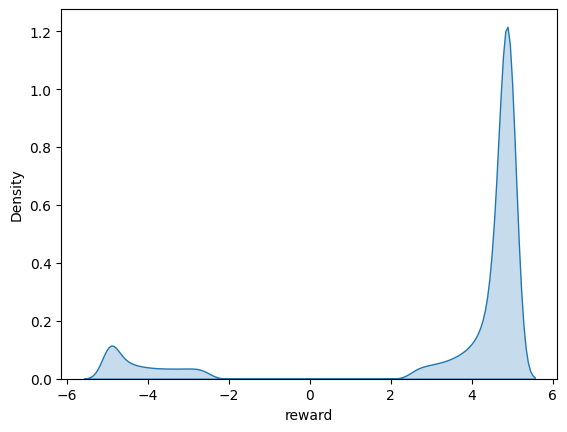

In [ ]:
import  seaborn as sns
import matplotlib.pyplot as plt

# Plot
sns.kdeplot(data=recipes_df['reward'], fill=True)
plt.show()

In [ ]:
# Define aggregation functions
def aggregate_data(df):
    # Define how to aggregate numeric columns
    aggregated_data = {
        'reward': df['reward'].mean(),  # Average reward
        #Else choose the first since they are equal for each recipe id
        'name': df['name'].iloc[0],
        'description': df['description'].iloc[0],
        'ingredients': df['ingredients'].iloc[0],
        'steps': df['steps'].iloc[0],
        'nutrition': df['nutrition'].iloc[0],
        'minutes': df['minutes'].iloc[0]

    }

    return pd.Series(aggregated_data)

# Group the DataFrame by recipe_id and aggregate using the function
grouped_df = recipes_df.groupby('recipe_id').apply(aggregate_data).reset_index()

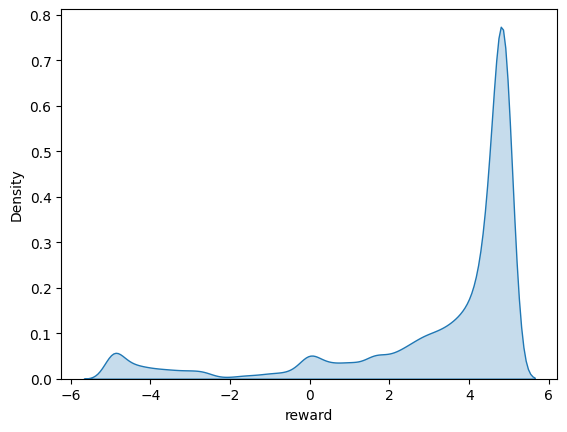

In [ ]:
# Plot
sns.kdeplot(data=grouped_df['reward'], fill=True)
plt.show()

In [ ]:
reward_threshold = 2.0

In [ ]:
grouped_df = grouped_df[grouped_df['reward'] > reward_threshold]

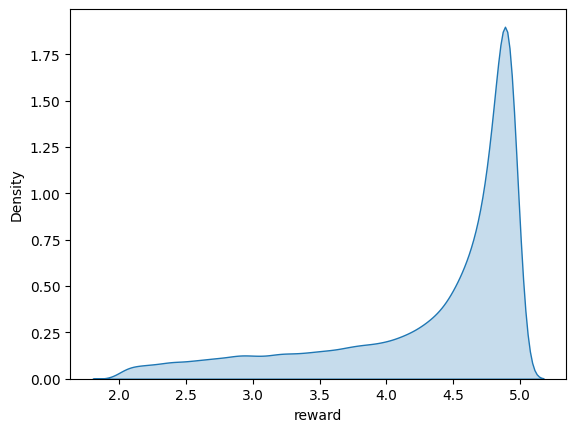

In [ ]:
# Plot
sns.kdeplot(data=grouped_df['reward'], fill=True)
plt.show()

In [ ]:
import ast

nutrients = [
        'calories',
        'fat',
        'sugar',
        'sodium',
        'protein',
        'saturated_fat',
        'carbohydrates'
 ]
def convert_pdv_to_grams(nutrient, pdv):
    daily_values = {
        'fat': 78,  # grams
        'sugar': 50,  # grams
        'sodium': 2300,  # milligrams
        'protein': 50,  # grams
        'saturated_fat': 20,  # grams
        'carbohydrates': 275,  # grams
    }

    if nutrient=='calories':
        return pdv  # number of calories

    # Convert the PDV to an actual amount
    if nutrient in daily_values:
        amount = daily_values[nutrient] * pdv / 100
        # Convert sodium to grams if necessary
        # if nutrient == 'sodium':
        #     amount /= 1000
        return amount
    else:
        raise ValueError(f"Nutrient '{nutrient}' is not recognized or supported.")

def step_format(i, step):
   return " " + str(i+1) + ". " + step


def convert_nutritional_info(row):
    # Formatting nutrition data
    # Example nutrition format in the DataFrame: [calories, fat, sugar, sodium, protein, sat_fat, fiber]
    nutrition_list = ast.literal_eval(row['nutrition'])
    nutrition = [convert_pdv_to_grams(nutrients[i], nutrition_list[i]) for i in range(len(nutrition_list))]
    return nutrition


In [ ]:
grouped_df[['nutrition']].head()

,nutrition
0,"[170.9, 3.0, 120.0, 1.0, 6.0, 6.0, 12.0]"
2,"[311.1, 0.0, 308.0, 0.0, 0.0, 0.0, 27.0]"
3,"[536.1, 36.0, 128.0, 64.0, 58.0, 19.0, 21.0]"
6,"[4.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
7,"[627.7, 38.0, 8.0, 35.0, 115.0, 64.0, 4.0]"


In [ ]:
grouped_df['nutrition_grams'] = grouped_df.apply(convert_nutritional_info, axis=1)

In [ ]:
grouped_df[['nutrition_grams']].head()

,nutrition_grams
0,"[170.9, 2.34, 60.0, 23.0, 3.0, 1.2, 33.0]"
2,"[311.1, 0.0, 154.0, 0.0, 0.0, 0.0, 74.25]"
3,"[536.1, 28.08, 64.0, 1472.0, 29.0, 3.8, 57.75]"
6,"[4.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
7,"[627.7, 29.64, 4.0, 805.0, 57.5, 12.8, 11.0]"


In [ ]:
grouped_df.columns

Index(['recipe_id', 'reward', 'name', 'description', 'ingredients', 'steps',
       'nutrition', 'minutes', 'nutrition_grams'],
      dtype='object')

In [ ]:
nutrients = [
        'calories',
        'fat',
        'sugar',
        'sodium',
        'protein',
        'saturated_fat',
        'carbohydrates'
 ]

In [ ]:
df = grouped_df.copy()

In [ ]:
# List of nutrients
nutrients = [
    'calories',
    'fat',
    'sugar',
    'sodium',
    'protein',
    'saturated_fat',
    'carbohydrates'
]

# Expanding 'nutrition_grams' into separate columns
df[nutrients] = pd.DataFrame(df['nutrition_grams'].tolist(), index=df.index)


In [ ]:
df.head()

,recipe_id,reward,name,description,ingredients,steps,nutrition,minutes,nutrition_grams,calories,fat,sugar,sodium,protein,saturated_fat,carbohydrates
0,38,4.694808,Low Fat Berry Blue Frozen Dessert,"this is yummy and low-fat, it always turns out...","['blueberries', 'granulated sugar', 'vanilla y...","['toss 2 cups berries with sugar', 'let stand ...","[170.9, 3.0, 120.0, 1.0, 6.0, 6.0, 12.0]",1485,"[170.9, 2.34, 60.0, 23.0, 3.0, 1.2, 33.0]",170.9,2.34,60.0,23.0,3.0,1.2,33.00
2,40,3.510922,Best Lemonade,this is from one of my first good house keepi...,"['sugar', 'lemons, rind of', 'fresh water', 'f...","['into a 1 quart jar with tight fitting lid , ...","[311.1, 0.0, 308.0, 0.0, 0.0, 0.0, 27.0]",35,"[311.1, 0.0, 154.0, 0.0, 0.0, 0.0, 74.25]",311.1,0.00,154.0,0.0,0.0,0.0,74.25
3,41,4.548118,Carina S Tofu Vegetable Kebabs,this dish is best prepared a day in advance to...,"['extra firm tofu', 'eggplant', 'zucchini', 'r...","['drain the tofu , carefully squeezing out exc...","[536.1, 36.0, 128.0, 64.0, 58.0, 19.0, 21.0]",1460,"[536.1, 28.08, 64.0, 1472.0, 29.0, 3.8, 57.75]",536.1,28.08,64.0,1472.0,29.0,3.8,57.75
6,46,4.655985,A Jad Cucumber Pickle,it is a traditional accompaniment to snacks su...,"['rice vinegar', 'thangkwa', 'hom daeng', 'nam...","['slice the cucumber in four lengthwise , then...","[4.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",25,"[4.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",4.3,0.00,0.0,0.0,0.0,0.0,0.00
7,49,4.729729,Chicken Breasts Lombardi,"cheese, chicken, and mushrooms with marsala.","['fresh mushrooms', 'butter', 'boneless skinle...",['cook mushrooms in 2 tbsp butter in a large s...,"[627.7, 38.0, 8.0, 35.0, 115.0, 64.0, 4.0]",75,"[627.7, 29.64, 4.0, 805.0, 57.5, 12.8, 11.0]",627.7,29.64,4.0,805.0,57.5,12.8,11.00


In [ ]:
df.shape

(180838, 16)

In [ ]:
df.to_csv("fitness_data/high_reward_meals.csv")